## Exercise 2d)

In [6]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity, ReLU, LeakyReLU
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset, runge, plot_mse_data, analyze_model_learning_rates
from copy import deepcopy

plt.style.use('./utils/_plot_style.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Generate dataset
np.random.seed(124)

n = 500
x, y = generate_dataset(n)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=44)

# Scale dataset
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_mean = y_train.mean()

In [8]:
# OLS model
ols_model = make_pipeline(
    PolynomialFeatures(degree=12, include_bias=False),
    StandardScaler(),
    LinearRegression(fit_intercept=False)
)

In [9]:
# Define models

nodes = list(range(5,25,5))
hidden_layers = [1,2,3]

activation_funcs = [
    ("Sigmoid", Sigmoid()),
    ("ReLU", ReLU()), 
    ("LeakyReLU",LeakyReLU())
]

training_methods = ("SGD", StochasticGradientDescent, (-4, 0))
step_methods = ("ADAM", AdamStep(0, 0.9, 0.999))

'''
# Define training methods
training_methods: list[tuple[str, type[TrainingMethod], tuple[int, int]]] = [
    ("SGD", StochasticGradientDescent, (-4, 0)),
    ("GD", GradientDescent, (-6, -2)),
]

# Step methods
step_methods: list[tuple[str, StepMethod]] = [
    ("RMSprop", RMSpropStep(0, 0.9)), 
    ("ADAM", AdamStep(0, 0.9, 0.999))
]
'''

'\n# Define training methods\ntraining_methods: list[tuple[str, type[TrainingMethod], tuple[int, int]]] = [\n    ("SGD", StochasticGradientDescent, (-4, 0)),\n    ("GD", GradientDescent, (-6, -2)),\n]\n\n# Step methods\nstep_methods: list[tuple[str, StepMethod]] = [\n    ("RMSprop", RMSpropStep(0, 0.9)), \n    ("ADAM", AdamStep(0, 0.9, 0.999))\n]\n'

In [10]:
n_learning_rates = 9
iterations = 3000
all_mse_data = np.zeros((len(nodes), len(hidden_layers), len(activation_funcs),n_learning_rates))

# Analyze mse vs. learning rate and number of nodes for different numbers of hidden layers and activation functions. 
for i, n_nodes in enumerate(nodes):
    print("Node: ",n_nodes)
    for j, n_hidden_layers in enumerate(hidden_layers):
        for k, (name,activation_func) in enumerate(activation_funcs):
            _,training_method, (min_log_lr,max_log_lr) = training_methods

            learning_rates = list(np.logspace(min_log_lr, max_log_lr, n_learning_rates))

            model = NeuralNetwork(
                    network_input_size = 1,
                    layer_output_sizes = [n_nodes]*n_hidden_layers  + [1],
                    activation_funcs = [activation_func]*n_hidden_layers + [Identity()],
                    cost_fun = MSE()
                    )

            np.random.seed(124)
            mse_data = analyze_model_learning_rates(
                model,
                training_method(
                    step_method = step_methods[1],
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                learning_rates, 
                iterations,
            )
            print(".")
            all_mse_data[i][j][k] = mse_data

Node:  5
.
.
.
.
.
.
.
.
.
Node:  10
.
.
.
.
.
.
.
.
.
Node:  15
.
.
.
.
.
.
.
.
.
Node:  20
.
.
.
.
.
.
.
.
.


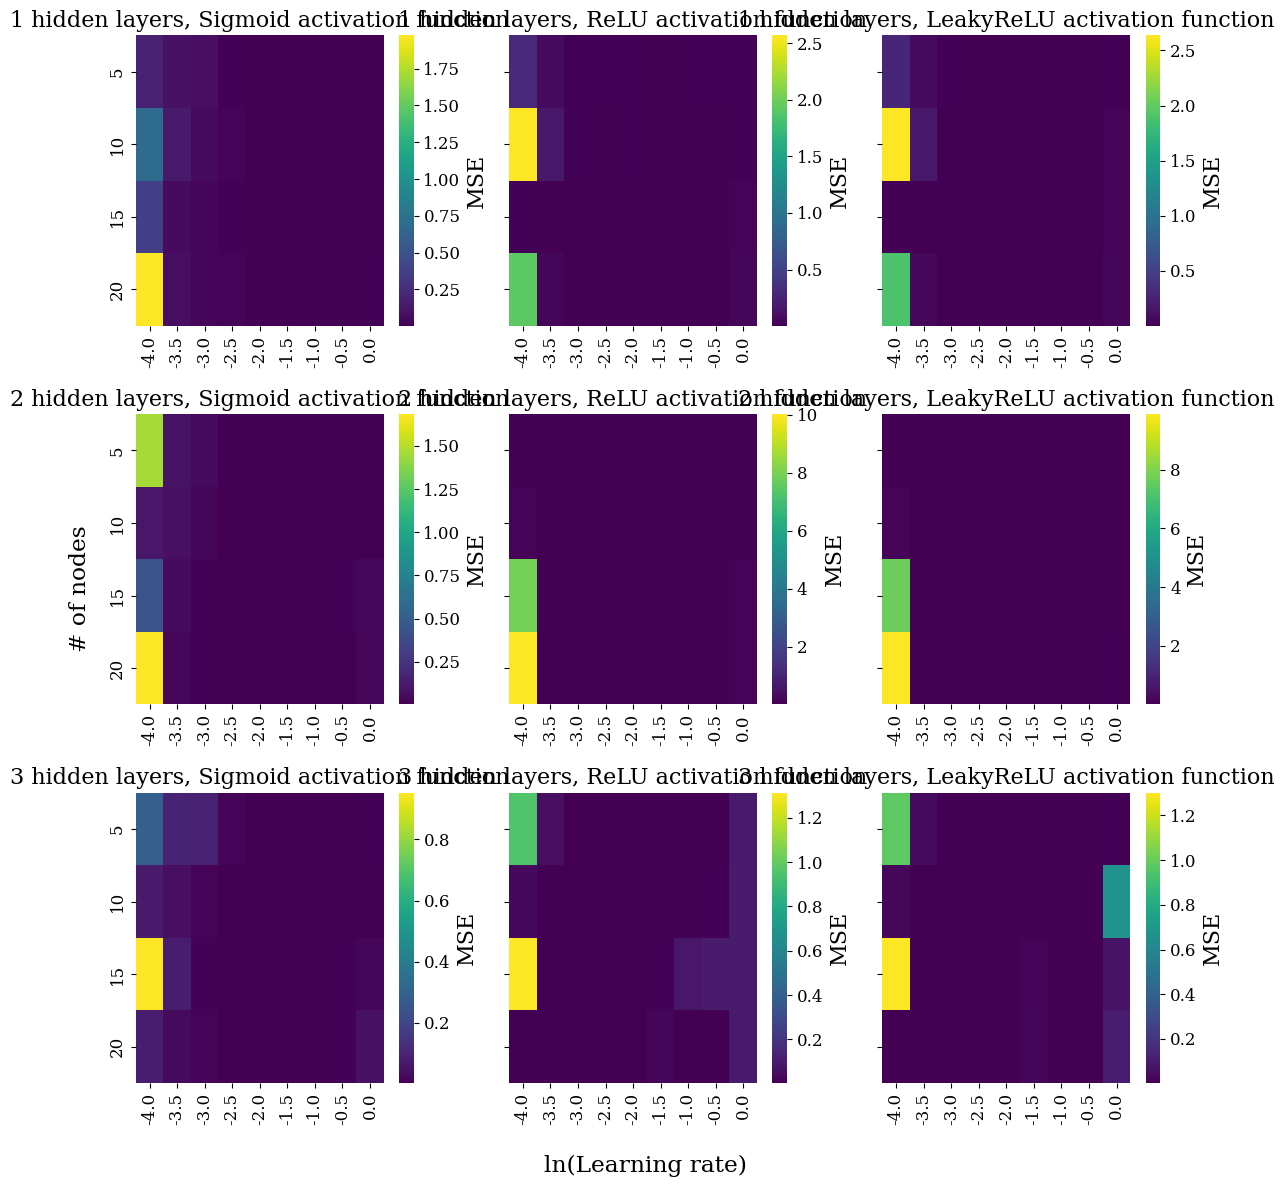

In [ ]:
# Plot MSE vs. learning rates for each model

import seaborn as sns

fig, axes = plt.subplots(len(hidden_layers), len(activation_funcs), figsize=(12, 12), sharey=True)
for j,n_hidden_layers in enumerate(hidden_layers):
    for k, (name,activation_func) in enumerate(activation_funcs):
        mse_data = all_mse_data[:,j,k,:]
        sns.heatmap(
            np.log10(np.array(mse_data)),  
            ax = axes[j,k],
            fmt=".2f",   
            cmap="viridis", 
            xticklabels=np.log10(np.array(learning_rates)),
            yticklabels=nodes,cbar_kws={"label": r"$log_10$(MSE)"}
            )
        axes[j,k].set_title(fr"{n_hidden_layers}, {name}")

    fig.supxlabel(r"$log_{10}$(Learning rate)")
    fig.supylabel("# of nodes")
plt.savefig("../figs/mse_vs_lr_nodes.pdf")
plt.show()

In [ ]:
'''
all_mse_data = np.zeros((len(models), len(training_methods), len(step_methods),iterations,1))

# Analyze mse vs. learning rates for each combination of model, training method, and step method
for i, (model_title, model) in enumerate(models):
    print(model_title)
    for j, (training_method_name, training_method, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        print(f"\t{training_method_name} - LR range: [{10**min_log_lr:.1e}, {10**max_log_lr:.1e}]")
        for k, (step_method_name, step_method) in enumerate(step_methods):
            print(f"\t\t{step_method_name}", end="")

            learning_rates = list(np.log(max_log_lr))

            np.random.seed(124)
            mse_data = analyze_model_learning_rates(
                model,
                training_method(
                    step_method = step_method,
                    inputs = x_train_scaled,
                    targets = y_train - y_mean,
                    test_inputs = x_test_scaled,
                    test_targets = y_test - y_mean,
                ),
                learning_rates, 
                iterations,
                track_mse = True
            )
            print(".")
            all_mse_data[i][j][k] = mse_data


fig, axes = plt.subplots(1, len(models), figsize=(12, 4), sharey=True)
for i, (model_title, _) in enumerate(models):
    for j, (training_method_name, _, (min_log_lr, max_log_lr)) in enumerate(training_methods):
        learning_rate = max_log_lr
        for k, (step_method_name, _) in enumerate(step_methods):
            mse_data = all_mse_data[i][j][k][:][0]
            axes[i].plot(range(iterations), mse_data, 
                     label=f"{training_method_name} with {step_method_name}", 
                     c=f"C{k}", 
                     linestyle = "-" if j == 0 else "--",
            )
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Iterations")
axes[0].set_ylabel("MSE")
single_legends = axes[0].get_legend_handles_labels()
fig.legend(
    handles=single_legends[0], labels=single_legends[1], 
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=2, fancybox=True, shadow=True
)
plt.savefig("../figs/mse_vs_iterations_max_lr.pdf")
plt.show()
'''